### VERGE: Vector-Mode Regional Geospatial Encoding
# Model evaluation


Elsewhere we trained a model to predict geospatial entity type from the encodings of the things
in its vicinity. Here we run an evaluation.


## Processing Setup

In [1]:
# Google colab setup
import os
from google.colab import drive
drive.mount('/content/drive')
project_home = '/content/drive/MyDrive/Projects/verge'
os.chdir(project_home)
!pip install geo_encodings

Mounted at /content/drive


In [2]:
# Local processing setup
# project_home = '..'

## Notebook Setup

In [3]:
import pandas as pd
import numpy as np
import glob
import pickle
import os
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import copy
import json
from geo_encodings import MPPEncoder

import sys
sys.path.append(project_home)
from utils.geo_transformer_mem import VergeDataset, verge_collate_fn, GeospatialTransformer


## Parameters

In [11]:
# The name of the ROI to use.
roi_name = 'newengland'

# The name of the general-purpose data directory.
data_home = '%s/data' % (project_home)

# The name of the ROI-specific data directory.
roi_home = '%s/data/%s' % (project_home, roi_name)

# A unique identifier for this run.
run_id = '201b'

# This is the identifier of the splits file to use.
splits_id = '201'

# What type of device to train on.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device', device)


using device cuda


## Parameters

In [7]:
# Read the ROI definition.
fname = '%s/roi.json' % roi_home
with open(fname) as source:
    roi = json.load(source)

tile_size = roi['tile_size']
encoding_resolution = roi['encoding_resolution']

# We need the dimension of the encoding.
encoder = MPPEncoder(
    region=[0, 0, tile_size, tile_size],
    resolution=encoding_resolution,
    center=True
)
geo_encoding_dim = len(encoder)
print('%d elements in encodings' % geo_encoding_dim)


400 elements in encodings


## Preliminaries

In [8]:
# Read the list of labels.
fname = '%s/labels.csv' % data_home
labels = pd.read_csv(fname)
n_classes = len(labels)
print('%d labels in this dataset' % n_classes)

label_id_lookup = {
    z['label']: z['id']
    for z in labels.to_dict('records')
}

label_name_lookup = {
    z['id']: z['label']
    for z in labels.to_dict('records')
}

22 labels in this dataset


In [9]:
# Read the file that gives class probabilities.
fname = '%s/class_info.csv' % roi_home
class_info = pd.read_csv(fname)
print('%d class info records' % len(class_info))

22 class info records


## Load data
We determine which files to read by loading the associated "split" file.

In [12]:
splits_fname = '%s/models/splits-%s.csv' % (roi_home, splits_id)
splits = pd.read_csv(splits_fname)
aoi_tags = np.unique(splits[splits['split'] == 'val']['aoi_tag']).tolist()
print('%d aois with validation data' % len(aoi_tags))

val_fnames = []
for aoi_tag in aoi_tags:
    fname = '%s/encodings/%s.pkl' % (roi_home, aoi_tag)
    val_fnames.append(fname)


56 aois with validation data


## Prep model and data

In [13]:
# The dataset constructor requires a lookup table for class probabilities.
class_prob_lookup = {
    z['label']: z['prob']
    for z in class_info.to_dict('records')
}

val_dataset = VergeDataset(val_fnames, n_classes, mask_fraction=0.15, class_prob=class_prob_lookup)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=64, # Tune depending on GPU memory
    shuffle=True,
    collate_fn=verge_collate_fn,
    drop_last=False
)

loaded 29 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0688w-447n.pkl
loaded 36 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0689w-447n.pkl
loaded 39 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0701w-419n.pkl
loaded 41 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0705w-417n.pkl
loaded 62 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0705w-434n.pkl
loaded 61 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0707w-417n.pkl
loaded 40 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0707w-420n.pkl
loaded 58 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0707w-426n.pkl
loaded 57 instances from /content/drive/MyDrive/Projects/verge/data/newengland/encodings/0707w-431n.pkl
loaded 70 instances from /content/drive/MyDrive/Projects/verge/d

In [14]:
# Load the model.
model_fname = '%s/models/model-%s' % (roi_home, run_id)
model = torch.load(model_fname, weights_only=False)
print('loaded %s' % model_fname)

loaded /content/drive/MyDrive/Projects/verge/data/newengland/models/model-201b


## Validation Visualization

In [15]:
# Process the validation dataset, getting the class probability predictions
# for every instance.
model.to(device)
cases = []

model.eval()
for features, labels, attention_mask, idents in val_dataloader:

    features = features.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    logits = model(features, attention_mask)
    batch_size = logits.shape[0]
    for i in range(batch_size):
        case_logits = logits[i]
        case_probs = torch.softmax(case_logits, dim=1)
        case_labels = labels[i]
        entity_count = len(case_labels)
        for k in range(entity_count):
            if case_labels[k].item() >= 0: # Skips the "-100" labels.
                cases.append({
                    'true_label': case_labels[k].item(),
                    'probs': torch.Tensor.cpu(case_probs[k, :]).detach().numpy()
                })

print('compiled prediction probabilities for %d validation instances' % len(cases))

compiled prediction probabilities for 43095 validation instances


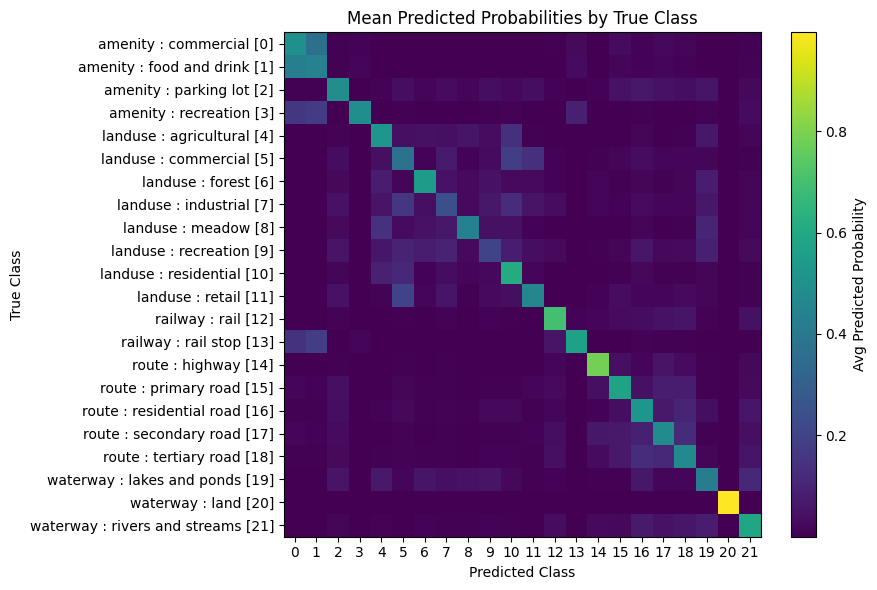

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class_count = max(d["true_label"] for d in cases) + 1
probs_by_class = defaultdict(list)

for d in cases:
    label = d["true_label"]
    probs = np.array(d["probs"])
    probs_by_class[label].append(probs)

# For each true class, compute the mean probability vector
mean_probs = []
for t in range(class_count):
    if probs_by_class[t]:
        mean = np.stack(probs_by_class[t]).mean(axis=0)
    else:
        mean = np.zeros(class_count)  # if no samples for this class
    mean_probs.append(mean)

# Convert to 2D array: [true_class, predicted_class]
matrix = np.stack(mean_probs)  # shape [C, C]

# Plot heatmap
fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(matrix, cmap='viridis', aspect='auto')

plt.colorbar(im, ax=ax, label='Avg Predicted Probability')
ax.set_title("Mean Predicted Probabilities by True Class")
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_xticks(range(class_count))
ax.set_yticks(range(class_count))
ax.set_yticklabels(['%s [%d]' % (label_name_lookup[i], i) for i in range(class_count)])
plt.tight_layout()
plt.show()



22


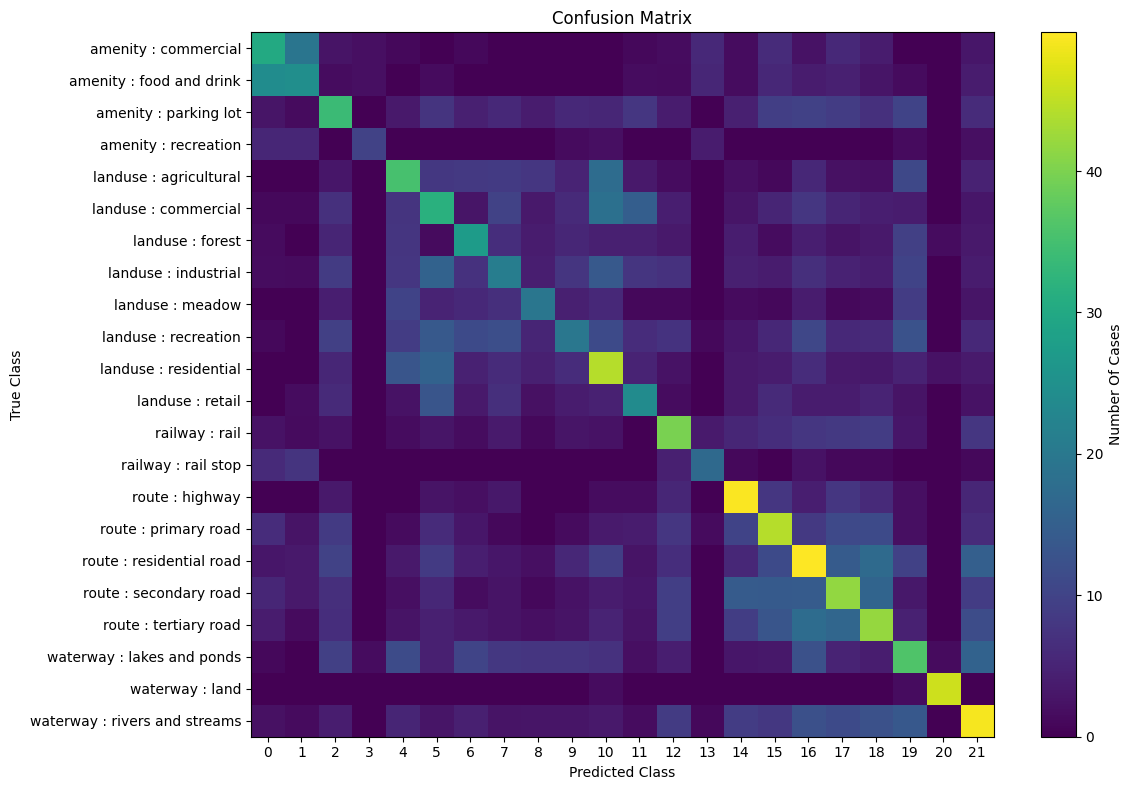

In [17]:
# Confusion matrix.

class_count = max(d["true_label"] for d in cases) + 1
print(class_count)
cmat = np.zeros((class_count, class_count))

for d in cases:
    true_label = d["true_label"]
    pred_label = np.argmax(d["probs"])
    cmat[true_label, pred_label] += 1

cmat = np.sqrt(cmat)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cmat, cmap='viridis', aspect='auto')

plt.colorbar(im, ax=ax, label='Number Of Cases')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_xticks(range(class_count))
ax.set_yticks(range(class_count))
ax.set_yticklabels([label_name_lookup[i] for i in range(class_count)])
plt.tight_layout()
plt.show()


In [18]:
# Accuracy stats

from sklearn.metrics import top_k_accuracy_score, f1_score

y_true = np.array([d["true_label"] for d in cases])
y_pred = np.array([np.argmax(d["probs"]) for d in cases])
y_prob = np.vstack([d["probs"] for d in cases])

all_labels = list(range(22))
print('top-1 accuracy: %.4f' % top_k_accuracy_score(y_true, y_prob, k=1, labels=all_labels))
print('top-2 accuracy: %.4f' % top_k_accuracy_score(y_true, y_prob, k=2, labels=all_labels))
print('top-3 accuracy: %.4f' % top_k_accuracy_score(y_true, y_prob, k=3, labels=all_labels))
print('top-4 accuracy: %.4f' % top_k_accuracy_score(y_true, y_prob, k=4, labels=all_labels))
print('top-5 accuracy: %.4f' % top_k_accuracy_score(y_true, y_prob, k=5, labels=all_labels))
print('f1 score: %.4f' % f1_score(y_true, y_pred, average='macro'))


top-1 accuracy: 0.6408
top-2 accuracy: 0.8163
top-3 accuracy: 0.8892
top-4 accuracy: 0.9290
top-5 accuracy: 0.9529
f1 score: 0.6204
